In [1]:
import arbor
print(arbor.__version__)
import numpy as np
import matplotlib.pyplot as plt

cell_id = 'BallAndStick'
nml = arbor.neuroml('%s.cell.nml'%cell_id)

cell_ids = nml.cell_ids()
morpho_data = nml.cell_morphology(cell_id)
morpho = morpho_data.morphology

# Get the region label dictionaries associated with the morphology.
morpho_segments = morpho_data.segments()
morpho_named = morpho_data.named_segments() # (label_dict)
morpho_groups = morpho_data.groups()

# Create new label dict add to it all the NeuroML dictionaries.
labels = arbor.label_dict()
labels.append(morpho_segments)
labels.append(morpho_named)
labels.append(morpho_groups)

print(nml)
print(morpho_segments)
print(morpho_segments.regions)
# >>> print([reg for reg in labels.regions if not reg.isdigit()])
# ['all', 'soma_group', 'dendrite_group', 'axon_group', ...]


0.5.1-dev
(label_dict (region  "0" (join nil (segment 0))) (region  "5" (join nil (segment 5))) (region  "7" (join nil (segment 7))) (region  "3" (join nil (segment 3))) (region  "1" (join nil (segment 1))) (region  "2" (join nil (segment 2))) (region  "10" (join nil (segment 10))) (region  "8" (join nil (segment 8))) (region  "4" (join nil (segment 4))) (region  "9" (join nil (segment 9))) (region  "6" (join nil (segment 6))))
['0', '5', '7', '3', '1', '2', '10', '8', '4', '9', '6']


In [13]:

# Add locsets to the label dictionary.
#labels['stim_site'] = '(on-components 0.5 (region "0"))' # site for the stimulus
labels['stim_site'] = '(location 0 0)' # site for the stimulus
#labels['axon_end']  = '(restrict (terminal) (region "axon_group"))' # end of the axon.
labels['dend_end']  = '(restrict (terminal) (region "dendrite_group"))' # end of the axon.
labels['root']      = '(root)' # the start of the soma in this morphology is at the root of the cell.


labels['soma'] = '(location 0 0.5)'
#labels['dend1'] = '(location 1 0.5)'
#labels['dend2'] = '(location 2 0.5)'

decor = arbor.decor()
policy = arbor.cv_policy_fixed_per_branch(11)
decor.discretization(policy)

decor.paint('"all"', arbor.mechanism('pas', dict(g=2.01e-05)))
decor.paint('"all"', rL=2000)

decor.place('"stim_site"', arbor.iclamp( 100, 200, 0.05))


# Combine morphology with region and locset definitions to make a cable cell.
cell = arbor.cable_cell(morpho, labels, decor)
print(cell.locations('"dend_end"'))

# Make single cell model.
m = arbor.single_cell_model(cell)

for i in range(11):
    m.probe('voltage', where='(location 0 %s)'%(i/10.),  frequency=500)


[(location 0 1)]


Simulation start.
Simulation done.
no spikes
(trace "voltage" (location 0 0))
(trace "voltage" (location 0 0.1))
(trace "voltage" (location 0 0.2))
(trace "voltage" (location 0 0.3))
(trace "voltage" (location 0 0.4))
(trace "voltage" (location 0 0.5))
(trace "voltage" (location 0 0.6))
(trace "voltage" (location 0 0.7))
(trace "voltage" (location 0 0.8))
(trace "voltage" (location 0 0.9))
(trace "voltage" (location 0 1))


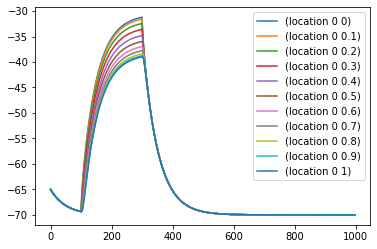

In [14]:



# Simulate the cell
print('Simulation start.')
tfinal = 1000 # ms
m.run(tfinal)
print('Simulation done.')


# Print spike times.
if len(m.spikes)>0:
    print('{} spikes:'.format(len(m.spikes)))
    for s in m.spikes:
        print('  {:7.4f}'.format(s))
else:
    print('no spikes')

for tr in m.traces:
    print(tr)
    x = np.array(tr.value)
    t = np.array(tr.time)
    plt.plot(t, x, label=tr.location)

    with open('%s.dat'%str(tr.location).replace(' ','_').replace('(','_').replace(')','_'),'w') as f:
        for ti in range(len(t)):
            f.write('%s\t%s\n'%(t[ti]/1000.0,x[ti]/1000.0))
plt.legend()
plt.show()